In [1]:
!pip install panns-inference transformers pretty_midi -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 48.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.4 MB/s eta 0:00:00


In [2]:
# =====================
# IMPORTS & BASIC SETUP
# =====================

import os
import glob
import warnings

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import librosa
import pretty_midi
import torchvision.models as models
import torchvision.transforms as T

from transformers import BertTokenizer, BertModel
from panns_inference import AudioTagging

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

2025-12-03 15:51:07.942151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764777068.087465      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764777068.128868      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

--2025-12-03 15:51:22--  http://storage.googleapis.com/us_audioset/youtube_corpus/v1/csv/class_labels_indices.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.207, 64.233.188.207, 74.125.204.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.207|:80... connected.
HTTP request sent, awaiting response... 

Device: cuda


200 OK
Length: 14675 (14K) [application/octet-stream]
Saving to: ‘/root/panns_data/class_labels_indices.csv’

     0K .......... ....                                       100%  117M=0s

2025-12-03 15:51:23 (117 MB/s) - ‘/root/panns_data/class_labels_indices.csv’ saved [14675/14675]



In [3]:
# ============= DATA PATH (Kaggle) =============
DATA_ROOT   = "/kaggle/input/multimodal-mirex-emotion-dataset/dataset"
AUDIO_DIR   = f"{DATA_ROOT}/Audio"
LYRICS_DIR  = f"{DATA_ROOT}/Lyrics"
MIDI_DIR    = f"{DATA_ROOT}/MIDIs"

CATEGORIES_TXT = f"{DATA_ROOT}/categories.txt"
CLUSTERS_TXT   = f"{DATA_ROOT}/clusters.txt"

In [4]:
# ============= HYPERPARAMETERS =============
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

TEST_SIZE = 0.15
K_FOLDS   = 3
LR        = 1e-3
EPOCHS    = 30
BATCH     = 32

SR          = 32000
AUDIO_LEN   = 30
MAX_LEN_LYR = 256
WINDOW_SEC  = 30
FS          = 10

In [5]:
# 1) List semua file audio dan file_id
audio_files = sorted(glob.glob(os.path.join(AUDIO_DIR, "*.mp3")))
file_ids = [os.path.splitext(os.path.basename(x))[0] for x in audio_files]

print("Total audio files:", len(file_ids))

# 2) Load categories.txt (kategori per sample)
with open(CATEGORIES_TXT, "r", encoding="utf-8") as f:
    categories = [x.strip() for x in f.readlines()]

print("Loaded categories:", len(categories))

# 3) Load clusters.txt (cluster per sample, string 'Cluster 1' dst.)
with open(CLUSTERS_TXT, "r", encoding="utf-8") as f:
    clusters = [x.strip() for x in f.readlines()]

print("Loaded clusters:", len(clusters))

# 4) Validasi jumlah baris
assert len(file_ids) == len(categories), "Jumlah kategori != jumlah file audio"
assert len(file_ids) == len(clusters), "Jumlah cluster != jumlah file audio"

# 5) Perbaiki typo kategori jelas: 'Agressive' -> 'Aggressive'
categories = ["Aggressive" if c.lower() == "agressive" else c for c in categories]

# 6) Bentuk dataframe metadata awal
meta_df = pd.DataFrame({
    "file_id": file_ids,
    "category": categories,
    "cluster_name": clusters
})

# 7) Parse cluster_id numerik (1–5) dari string 'Cluster 1' dst.
def parse_cluster_id(x: str):
    x = str(x)
    if x.lower().startswith("cluster"):
        return int(x.replace("Cluster", "").strip())
    return None

meta_df["cluster_id"] = meta_df["cluster_name"].apply(parse_cluster_id)

# 8) Tambahkan path per modalitas
meta_df["audio_path"]  = meta_df["file_id"].apply(lambda x: os.path.join(AUDIO_DIR,  f"{x}.mp3"))
meta_df["lyrics_path"] = meta_df["file_id"].apply(lambda x: os.path.join(LYRICS_DIR, f"{x}.txt"))
meta_df["midi_path"]   = meta_df["file_id"].apply(lambda x: os.path.join(MIDI_DIR,   f"{x}.mid"))

# 9) Cek file exist
meta_df["has_audio"]  = meta_df["audio_path"].apply(os.path.exists)
meta_df["has_lyrics"] = meta_df["lyrics_path"].apply(os.path.exists)
meta_df["has_midi"]   = meta_df["midi_path"].apply(os.path.exists)

print("Dengan audio :", meta_df["has_audio"].sum())
print("Dengan lirik :", meta_df["has_lyrics"].sum())
print("Dengan MIDI  :", meta_df["has_midi"].sum())

# === TARGET TRAINING: 5 CLUSTER ===
# cluster_id: 1..5  -> cluster_idx: 0..4
meta_df["cluster_idx"] = meta_df["cluster_id"] - 1
num_classes = 5
cluster_label_names = [f"Cluster_{i}" for i in range(1, 6)]

# Kamus label untuk training & evaluasi: file_id -> cluster_idx
label_dict = dict(zip(meta_df["file_id"], meta_df["cluster_idx"]))

print("Using CLUSTER as target")
print("Num classes:", num_classes)
print("Cluster label names:", cluster_label_names)

# Base: minimal punya audio (audio = modalitas wajib)
base_df = meta_df[meta_df["has_audio"]].reset_index(drop=True)
print("Base (punya audio):", len(base_df))
cluster_labels = [f"Cluster_{i}" for i in range(1,6)]
meta_df.head()


Total audio files: 903
Loaded categories: 903
Loaded clusters: 903
Dengan audio : 903
Dengan lirik : 764
Dengan MIDI  : 196
Using CLUSTER as target
Num classes: 5
Cluster label names: ['Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4', 'Cluster_5']
Base (punya audio): 903


,file_id,category,cluster_name,cluster_id,audio_path,lyrics_path,midi_path,has_audio,has_lyrics,has_midi,cluster_idx
0,001,Boisterous,Cluster 1,1,/kaggle/input/multimodal-mirex-emotion-dataset...,/kaggle/input/multimodal-mirex-emotion-dataset...,/kaggle/input/multimodal-mirex-emotion-dataset...,True,True,False,0
1,002,Boisterous,Cluster 1,1,/kaggle/input/multimodal-mirex-emotion-dataset...,/kaggle/input/multimodal-mirex-emotion-dataset...,/kaggle/input/multimodal-mirex-emotion-dataset...,True,False,False,0
2,003,Boisterous,Cluster 1,1,/kaggle/input/multimodal-mirex-emotion-dataset...,/kaggle/input/multimodal-mirex-emotion-dataset...,/kaggle/input/multimodal-mirex-emotion-dataset...,True,True,False,0
3,004,Boisterous,Cluster 1,1,/kaggle/input/multimodal-mirex-emotion-dataset...,/kaggle/input/multimodal-mirex-emotion-dataset...,/kaggle/input/multimodal-mirex-emotion-dataset...,True,True,True,0
4,005,Boisterous,Cluster 1,1,/kaggle/input/multimodal-mirex-emotion-dataset...,/kaggle/input/multimodal-mirex-emotion-dataset...,/kaggle/input/multimodal-mirex-emotion-dataset...,True,False,False,0


## Load Encoder (Pretrained)

### Audio

In [6]:
# =======================
# LOAD PRETRAINED MODELS
# =======================

# ---- AUDIO: PANNs CNN14 ----
at_model = AudioTagging(checkpoint_path=None, device=device)
print("Loaded PANNs")

def extract_audio_emb(path):
    y, _ = librosa.load(path, sr=SR, mono=True)
    max_len = SR * AUDIO_LEN
    if len(y) < max_len:
        y = np.pad(y, (0, max_len-len(y)))
    else:
        y = y[:max_len]
    x = y[None, :]
    with torch.no_grad():
        _, emb = at_model.inference(x)
    return emb[0]   # (2048,)

Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth


--2025-12-03 15:51:29--  https://zenodo.org/record/3987831/files/Cnn14_mAP%3D0.431.pth?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.153, 137.138.52.235, 188.185.48.75, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.153|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/3987831/files/Cnn14_mAP=0.431.pth [following]
--2025-12-03 15:51:29--  https://zenodo.org/records/3987831/files/Cnn14_mAP=0.431.pth
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 327428481 (312M) [application/octet-stream]
Saving to: ‘/root/panns_data/Cnn14_mAP=0.431.pth’

     0K .......... .......... .......... .......... ..........  0% 91.7K 58m6s
    50K .......... .......... .......... .......... ..........  0%  230K 40m39s
   100K .......... .......... .......... .......... ..........  0% 12.3M 27m14s
   150K .......... .......... .......... .......... ..........  0%  235K 26m5s
   200K ......

Using CPU.
Loaded PANNs


### Lirik

In [7]:
# ---- LYRICS: BERT ----
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased").to(device).eval()
print("BERT Loaded")

def extract_lyrics_emb(path):
    with open(path,"r",encoding="utf-8",errors="ignore") as f:
        text = f.read()

    enc = tokenizer(text, max_length=MAX_LEN_LYR,
                    truncation=True, padding="max_length",
                    return_tensors="pt").to(device)

    with torch.no_grad():
        out = bert(**enc).last_hidden_state
        mask = enc["attention_mask"].unsqueeze(-1)
        pooled = (out*mask).sum(1) / mask.sum(1).clamp(min=1e-6)

    return pooled.squeeze(0).cpu().numpy()   # (768,)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERT Loaded


### Midi

In [8]:
# ---- MIDI: ResNet18 piano-roll ----
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet.fc = nn.Identity()
resnet = resnet.to(device).eval()

transform = T.Compose([
    T.ToTensor(),
    T.Resize((224,224)),
    T.Lambda(lambda x: x.repeat(3,1,1)),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

def midi_to_img(path):
    pm = pretty_midi.PrettyMIDI(path)
    dur = pm.get_end_time()
    if dur <= 0:
        raise ValueError("bad MIDI")

    end = min(WINDOW_SEC, dur)
    times = np.linspace(0,end,int(FS*end)+1)

    roll = pm.get_piano_roll(fs=FS,times=times)
    roll = (roll>0).astype(np.float32)

    return transform(roll)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 220MB/s]


In [9]:
def extract_midi_emb(path):
    img = midi_to_img(path).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = resnet(img)
    return emb.squeeze(0).cpu().numpy()  # (512,)

## Ekstraksi & Caching Embedding

In [10]:
audio_emb, lyrics_emb, midi_emb = {}, {}, {}
corrupt_midi = []

for _, row in tqdm(base_df.iterrows(), total=len(base_df)):
    fid = row.file_id

    # AUDIO
    try:
        audio_emb[fid] = extract_audio_emb(row.audio_path)
    except:
        continue

    # LYRICS
    if row.has_lyrics:
        try:
            lyrics_emb[fid] = extract_lyrics_emb(row.lyrics_path)
        except:
            pass

    # MIDI
    if row.has_midi:
        try:
            midi_emb[fid] = extract_midi_emb(row.midi_path)
        except:
            corrupt_midi.append(fid)

print("Audio emb:", len(audio_emb))
print("Lyrics emb:", len(lyrics_emb))
print("MIDI emb:", len(midi_emb))
print("Corrupt MIDI:", corrupt_midi)

  0%|          | 0/903 [00:00<?, ?it/s]

Audio emb: 903
Lyrics emb: 764
MIDI emb: 194
Corrupt MIDI: ['009', '097']


## Data Splitting

In [11]:
# =============================
# TRAINVAL / TEST SPLITTING
# =============================

base_ids = np.array(list(audio_emb.keys()))
labels   = np.array([label_dict[f] for f in base_ids])

idx = np.arange(len(base_ids))

idx_trval, idx_test = train_test_split(
    idx, test_size=TEST_SIZE, stratify=labels, random_state=RANDOM_SEED
)

trainval_ids = base_ids[idx_trval]
test_ids     = base_ids[idx_test]

print("TrainVal:", len(trainval_ids))
print("Test:", len(test_ids))

TrainVal: 767
Test: 136


## Dataset embedding + MLP classifier + train/eval helper

In [12]:
class EmbDataset(Dataset):
    def __init__(self, X, y, idx):
        self.X = X
        self.y = y
        self.idx = idx

    def __len__(self):
        return len(self.idx)

    def __getitem__(self, i):
        k = self.idx[i]
        return torch.tensor(self.X[k],dtype=torch.float32), torch.tensor(self.y[k])

In [13]:
class MLP(nn.Module):
    def __init__(self, dim, num_classes=5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim,256), nn.ReLU(), nn.Dropout(0.6),
            nn.Linear(256,num_classes)
        )
    def forward(self,x): return self.net(x)

## K-Fold unimodal + train final + ambil logits test

In [14]:
def train_one_epoch(model,loader,opt,crit):
    model.train()
    tot,correct,count=0,0,0
    for x,y in loader:
        x,y=x.to(device),y.to(device)
        logits=model(x)
        loss=crit(logits,y)
        opt.zero_grad(); loss.backward(); opt.step()

        tot+=loss.item()*y.size(0)
        pred=logits.argmax(1)
        correct+=(pred==y).sum().item()
        count+=y.size(0)
    return tot/count, correct/count


def eval_model(model,loader,crit):
    model.eval()
    tot,correct,count=0,0,0
    all_y, all_p = [],[]
    with torch.no_grad():
        for x,y in loader:
            x,y=x.to(device),y.to(device)
            logits=model(x)
            loss=crit(logits,y)
            tot+=loss.item()*y.size(0)
            pred=logits.argmax(1)
            correct+=(pred==y).sum().item()
            count+=y.size(0)
            all_y.extend(y.cpu().numpy())
            all_p.extend(pred.cpu().numpy())
    return tot/count, correct/count, np.array(all_y), np.array(all_p)

In [15]:
def kfold_train(name, emb_dict):
    # pilih subset yg punya modalitas
    ids = [fid for fid in trainval_ids if fid in emb_dict]
    X = np.stack([emb_dict[f] for f in ids])
    y = np.array([label_dict[f] for f in ids])

    print(f"\n===== {name}: {len(ids)} samples =====")
    dim = X.shape[1]

    skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)
    crit = nn.CrossEntropyLoss()

    fold1_hist = None
    fold_accs = []

    for fold,(tr,va) in enumerate(skf.split(X,y),1):
        trds = EmbDataset(X,y,tr)
        vads = EmbDataset(X,y,va)

        trl = DataLoader(trds,BATCH,shuffle=True)
        val = DataLoader(vads,BATCH)

        model = MLP(dim).to(device)
        opt = torch.optim.AdamW(model.parameters(), lr=LR)

        if fold==1:
            fold1_hist = {"epoch":[],"train_loss":[],"train_acc":[],"val_loss":[],"val_acc":[]}

        print(f"\n{name} Fold {fold}/{K_FOLDS}")

        for ep in range(1,EPOCHS+1):
            tl,ta = train_one_epoch(model,trl,opt,crit)
            vl,va_acc,_,_ = eval_model(model,val,crit)

            if fold==1:
                fold1_hist["epoch"].append(ep)
                fold1_hist["train_loss"].append(tl)
                fold1_hist["train_acc"].append(ta)
                fold1_hist["val_loss"].append(vl)
                fold1_hist["val_acc"].append(va_acc)

            if ep==1 or ep%5==0:
                print(f"Ep{ep}: TL={tl:.3f} TA={ta:.3f} | VL={vl:.3f} VA={va_acc:.3f}")

        fold_accs.append(va_acc)

    print(f"\n{name} Mean Val Acc:", np.mean(fold_accs))

    # ---- Final Training ----
    print(f"{name}: Training Final Model...")
    full = EmbDataset(X,y,np.arange(len(X)))
    loader = DataLoader(full,BATCH,shuffle=True)

    model_final = MLP(dim).to(device)
    opt = torch.optim.AdamW(model_final.parameters(), lr=LR)

    for ep in range(1,EPOCHS+1):
        tl,ta = train_one_epoch(model_final,loader,opt,crit)
        if ep==1 or ep%5==0:
            print(f"[Final {name}] Ep{ep}: TL={tl:.3f} TA={ta:.3f}")

    return model_final, fold1_hist

In [16]:
def plot_curve(hist, title):
    if hist is None:
        print("No history:", title)
        return

    e = hist["epoch"]
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(e,hist["train_loss"],label="Train Loss")
    plt.plot(e,hist["val_loss"],label="Val Loss")
    plt.title("Train vs Val Loss"); plt.grid(); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(e,hist["train_acc"],label="Train Acc")
    plt.plot(e,hist["val_acc"],label="Val Acc")
    plt.title("Train vs Val Accuracy"); plt.grid(); plt.legend()

    plt.suptitle(title)
    plt.show()

## Training


===== Audio: 767 samples =====

Audio Fold 1/3
Ep1: TL=1.555 TA=0.292 | VL=1.478 VA=0.402
Ep5: TL=1.297 TA=0.434 | VL=1.291 VA=0.504
Ep10: TL=1.157 TA=0.509 | VL=1.261 VA=0.520
Ep15: TL=1.067 TA=0.560 | VL=1.243 VA=0.496
Ep20: TL=0.999 TA=0.605 | VL=1.253 VA=0.500
Ep25: TL=0.952 TA=0.644 | VL=1.283 VA=0.484
Ep30: TL=0.863 TA=0.683 | VL=1.319 VA=0.469

Audio Fold 2/3
Ep1: TL=1.566 TA=0.294 | VL=1.489 VA=0.410
Ep5: TL=1.216 TA=0.499 | VL=1.381 VA=0.422
Ep10: TL=1.112 TA=0.552 | VL=1.399 VA=0.453
Ep15: TL=0.997 TA=0.618 | VL=1.441 VA=0.465
Ep20: TL=0.875 TA=0.677 | VL=1.488 VA=0.441
Ep25: TL=0.834 TA=0.681 | VL=1.540 VA=0.418
Ep30: TL=0.776 TA=0.714 | VL=1.645 VA=0.414

Audio Fold 3/3
Ep1: TL=1.573 TA=0.258 | VL=1.471 VA=0.431
Ep5: TL=1.304 TA=0.453 | VL=1.255 VA=0.486
Ep10: TL=1.202 TA=0.543 | VL=1.221 VA=0.490
Ep15: TL=1.083 TA=0.562 | VL=1.205 VA=0.467
Ep20: TL=1.009 TA=0.613 | VL=1.208 VA=0.494
Ep25: TL=0.926 TA=0.660 | VL=1.225 VA=0.443
Ep30: TL=0.852 TA=0.688 | VL=1.260 VA=0.463

A

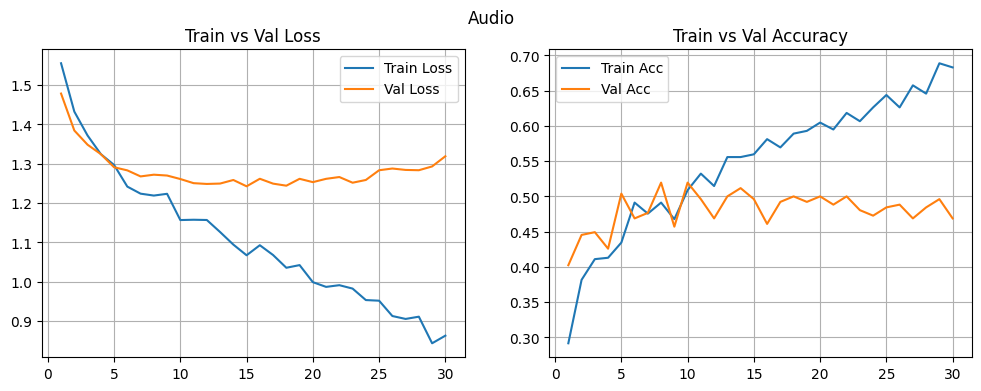

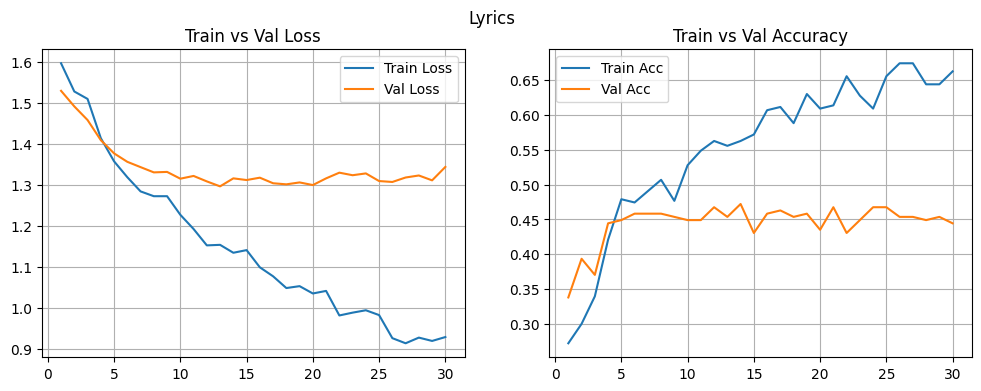

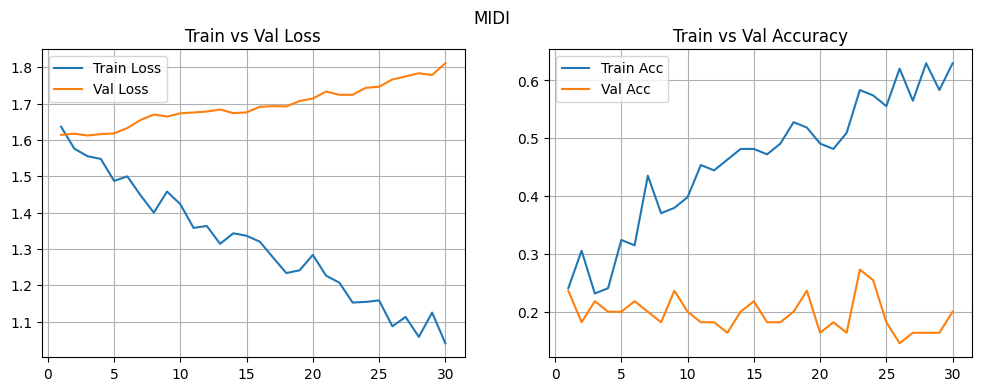

In [17]:
audio_model,  audio_hist  = kfold_train("Audio",  audio_emb)
lyrics_model, lyrics_hist = kfold_train("Lyrics", lyrics_emb)
midi_model,   midi_hist   = kfold_train("MIDI",   midi_emb)

plot_curve(audio_hist,"Audio")
plot_curve(lyrics_hist,"Lyrics")
plot_curve(midi_hist,"MIDI")

## Late Fusion

In [18]:
def test_logits(model, emb_dict):
    logits = {}
    crit = nn.CrossEntropyLoss()

    ids = [fid for fid in test_ids if fid in emb_dict]
    X = np.stack([emb_dict[f] for f in ids])
    y = np.array([label_dict[f] for f in ids])

    ds = EmbDataset(X,y,np.arange(len(X)))
    ld = DataLoader(ds,BATCH)

    _,acc,_,_ = eval_model(model,ld,crit)
    print("Test Acc:", acc)

    with torch.no_grad():
        for fid,x in zip(ids,X):
            t = torch.tensor(x).float().unsqueeze(0).to(device)
            logits[fid] = model(t)[0].cpu().numpy()
    return logits

In [19]:
audio_logits  = test_logits(audio_model,  audio_emb)
lyrics_logits = test_logits(lyrics_model, lyrics_emb)
midi_logits   = test_logits(midi_model,   midi_emb)

Test Acc: 0.40441176470588236
Test Acc: 0.4067796610169492
Test Acc: 0.3225806451612903


In [20]:
y_true, y_pred = [], []

for fid in test_ids:
    y = label_dict[fid]
    log = []

    if fid in audio_logits:  log.append(audio_logits[fid])
    if fid in lyrics_logits: log.append(lyrics_logits[fid])
    if fid in midi_logits:   log.append(midi_logits[fid])

    if len(log)==0:
        continue

    fused = np.mean(log,axis=0)
    y_true.append(y)
    y_pred.append(fused.argmax())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("\nLate Fusion Acc:", accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred,target_names=cluster_labels))


Late Fusion Acc: 0.4485294117647059
              precision    recall  f1-score   support

   Cluster_1       0.18      0.12      0.14        26
   Cluster_2       0.62      0.20      0.30        25
   Cluster_3       0.49      0.84      0.62        32
   Cluster_4       0.47      0.28      0.35        29
   Cluster_5       0.46      0.75      0.57        24

    accuracy                           0.45       136
   macro avg       0.44      0.44      0.40       136
weighted avg       0.45      0.45      0.40       136



<Figure size 600x600 with 0 Axes>

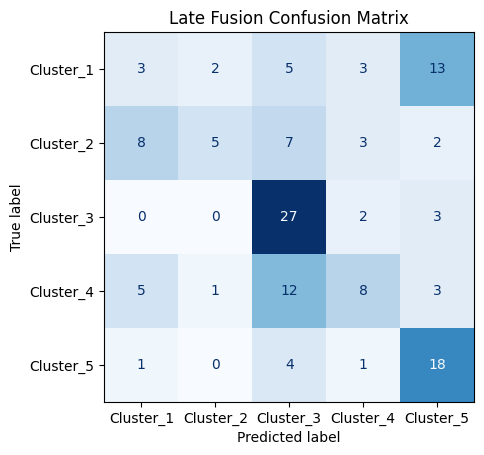

In [21]:
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=cluster_labels)
plt.figure(figsize=(6,6))
disp.plot(cmap="Blues", colorbar=False)
plt.title("Late Fusion Confusion Matrix")
plt.show()